# Compulsory Assignment 3: Semantic segmentation

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 30 \
**Group member 1**: Peder Ørmen Bukaasen \  
**Group member 2**: Bård Tollef Pedersen \
**Group member 3**: Evind Lid Trøen \
**Group name (optional)**: Pesi Morti \


# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. This is the biggest assignment of the semester, and therefore you get two weeks to work on it. However, we reccomend that **you start early**. This assignment has three semi-big sections, each of which build upon the last. So if you delay the assignment until the day before submission, you will most likely fail. This assignment is completed by doing the following.
* Submit notebook as an .ipynb file to canvas.
* Submit notebook as an .pdf file to canvas.
* Submit the python script you run on ORION to canvas.
* Submit the SLURM script you run on ORION to canvas.
* Submit at least one of your model predictions to the Kaggle leaderboard, and attain a score that is higher than the *BEAT ME* score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.


# Introduction
In the context of transportation, pilots need to identify possible urgent landing areas in forests.
Therefore, scientists have provided us with aerial photos of the forest and accompanying image
masks that indicate the presence of birch trees in the images. These masks are binary, with a value of
0 representing areas without birch trees and a value of 1 indicating the presence of birch trees. Our
objective is to utilize this dataset to train a model capable of performing semantic segmentation,
accurately identifying and delineating birch trees in the images.

## Dataset
In this assigmnet you will be given 3200 annotated images. The image, and mask dimensions are 128x128 pixels. With each image there follows an annotation mask where each pixel is classified as `1` (birch tree occurence) or `0` (not birch tree) The test-dataset contains 800 images, where no ground truth masks are given. To evaluate your model on the test dataset, submit your predictions to the Kaggle leaderboard.

## Assignment tasks

1. Familiarising: Before any modelling, visualise examples of the raw data and masks in
your Jupyter notebook.
2. Basic U-NET: Create a U-Net with optional dropout. Use a proportion of the images
for validation when training. The minimum requirement is to tune the following
parameters: number of convolutional filters, dropout and learning rate. Report
strategies and scores leading up to the final choice.
3. I recommend adding augmentation (both images and masks) and changing the loss
function, e.g. implementing F1 loss. Create a plot showing your model's predicted
mask on some images in the training set and compare to the correct mask.
4. Transfer learning: Create a U-Net where the encoder part of the U-Net uses a pretrained VGG16 (or some other similar pre-trained model)
3. This can be achieved by loading a pre-trained model, dropping the final layer and
freezing the weights. Add skip connections from the Conv2D layers of the VGG16-
based encoder to the expansion layers of the decoder.


## Submissions to the Kaggle leaderboard

Link to the Kaggle leaderboard will be posted in the Canvas assignment.

```python
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False)        # Remember to store the dataframe to csv without the nameless index column.
```

# Library imports
Feel free to import other packages as needed.

In [1]:
import time
from tqdm import tqdm # Cool progress bar
import random
import numpy as np
import pandas as pd
import h5py
import cv2
import re
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from tensorflow.keras.applications import EfficientNetB7
from sklearn.utils import shuffle
SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

# Data loading

Load the data from the HDF5 file `tree_train.h5` and `tree_test.h5` that is available on Canvas, and Kaggle.
The data should be loaded in the same manner as in CA2.

In [2]:
FILE_PATH = "tree_train.h5" # If data is in same directory as Jypyter File

with h5py.File(FILE_PATH,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X'])
    y_train = np.asarray(f['y'])
    print('Nr. train images: %i'%(X_train.shape[0]))

Datasets in file: ['X', 'y']
Nr. train images: 3200


# Visualization

Plot a few samples images and masks. \
Feel free to visualize any other aspects of the dataset that you feel are relevant.

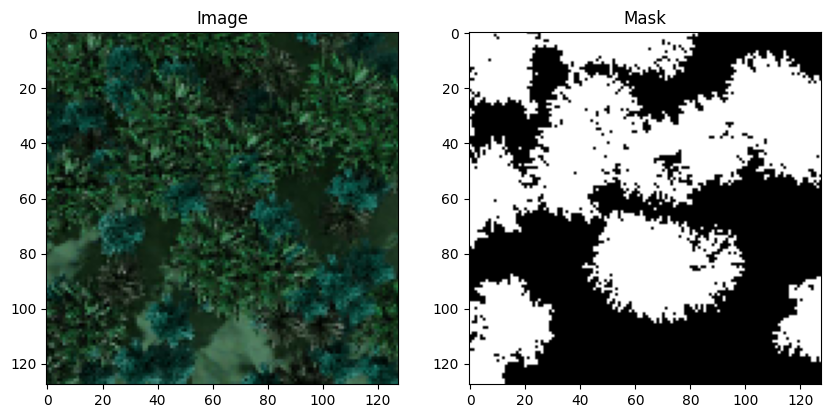

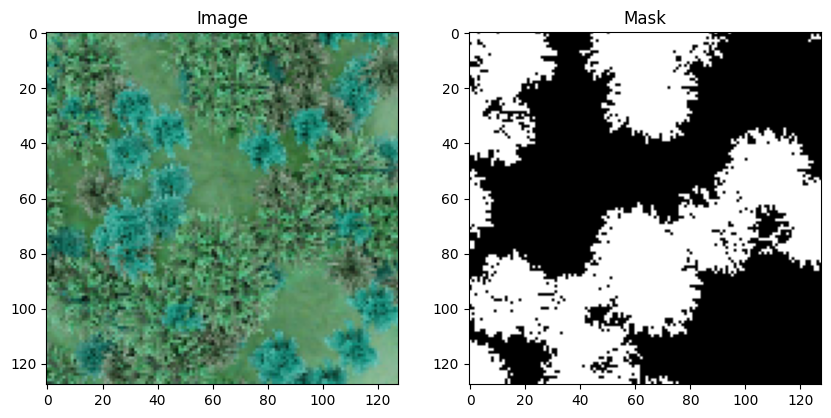

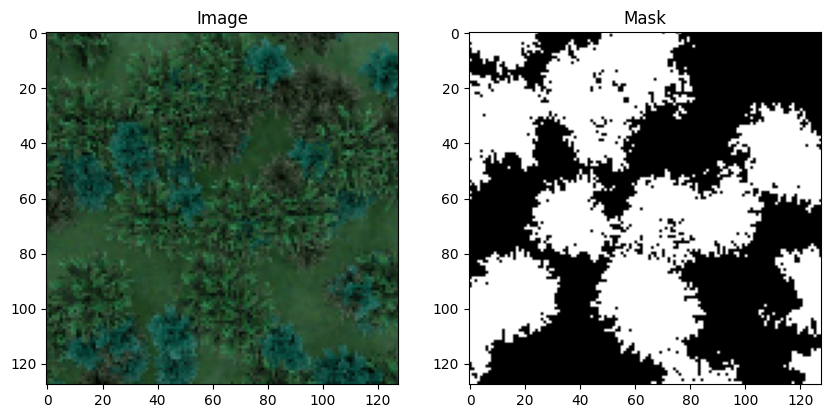

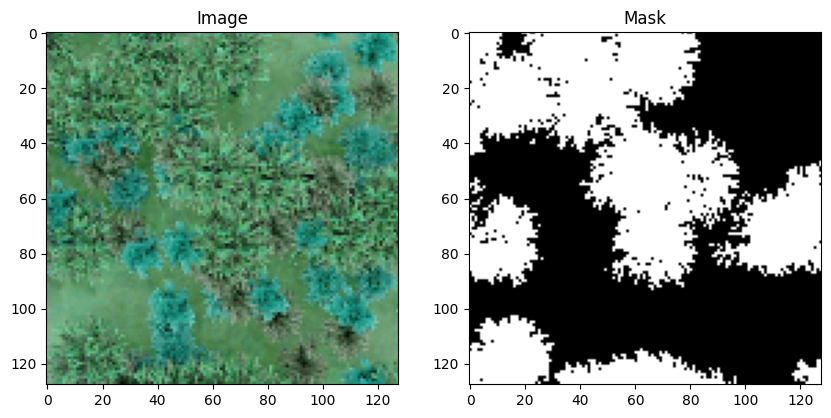

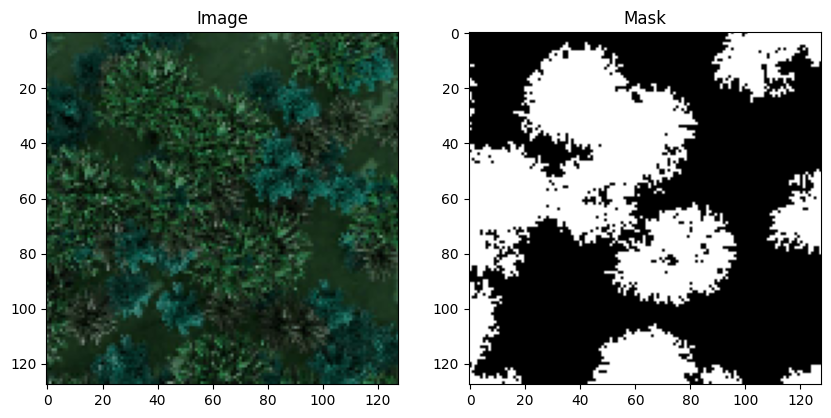

In [3]:
random_numbers = RNG.integers(0, X_train.shape[0], size=5)
for i in random_numbers:
  image = X_train[i]
  mask = y_train[i]
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(image)
  axes[0].set_title('Image')
  axes[1].imshow(mask, cmap='gray')
  axes[1].set_title('Mask')
  plt.show()

# Preprocessing

Preprocess the dataset in whatever ways you think are helpful. \
Tips: Perhaps you preprocess the different models in different ways?

In [4]:
# Turn to grey scale images
#X_train = np.expand_dims(X_train, -1)
X_train = X_train.astype("float32")/255

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))

In [5]:
zoom = tf.keras.layers.RandomZoom(0.5)
flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
rotate = tf.keras.layers.RandomRotation(1)
translation = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
contrast = tf.keras.layers.RandomContrast(0.9)

def augment(combined_image):
    augmentations = [zoom, flip, rotate, translation, contrast]
    num_augmentations = np.random.choice([1, 2])
    chosen_augmentations = np.random.choice(augmentations, num_augmentations, replace=False)
    for augmentation in chosen_augmentations:
        combined_image = augmentation(combined_image)

    rotated_x_image = combined_image[..., :3]
    rotated_y_image = combined_image[..., 3:]
    return rotated_x_image, rotated_y_image

def agument_all(X_train, y_train, n):
    augmented_X = []
    augmented_y = []

    for i in tqdm(range(n)):
        random_index = RNG.integers(0, X_train.shape[0])
        rotated_x_image, rotated_y_image = augment(np.concatenate([X_train[random_index], y_train[random_index]], axis=-1))
        augmented_X.append(rotated_x_image)
        augmented_y.append(rotated_y_image)

    # Convert lists to numpy arrays and concatenate with the original arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    X_train = np.concatenate([X_train, augmented_X], axis=0)
    y_train = np.concatenate([y_train, augmented_y], axis=0)

    return X_train, y_train

samples_to_generate = 4000
X_train, y_train = agument_all(X_train, y_train, samples_to_generate)

100%|██████████| 4000/4000 [00:46<00:00, 85.28it/s]


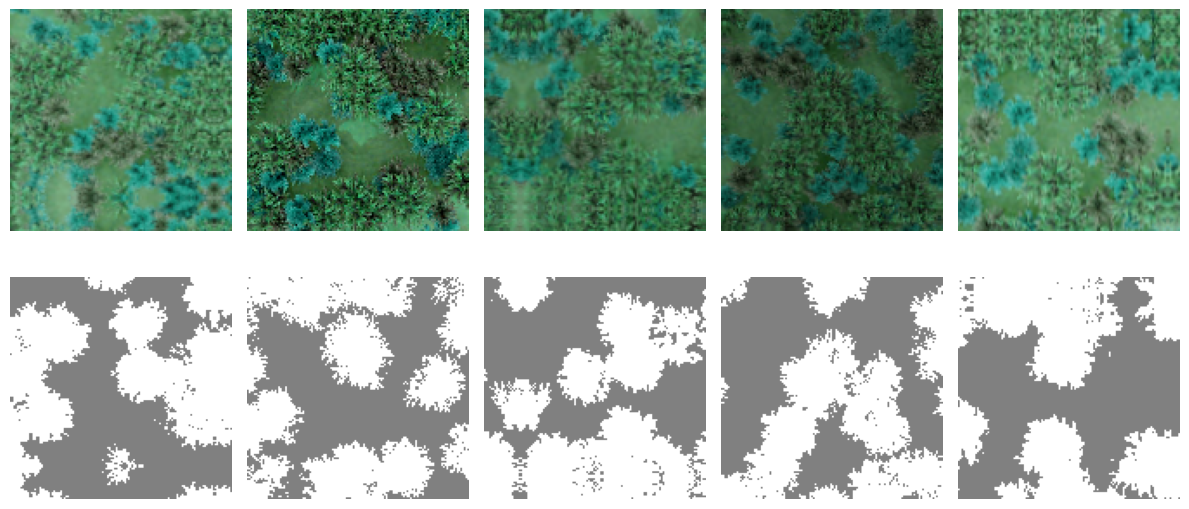

In [6]:
plt.figure(figsize=(12, 6))

for i in range(5):
    index = - (5 - i)
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[index])
    plt.axis("off")

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(np.argmax(y_train[index], axis=-1), cmap='gray', alpha=0.5)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
# Shuffle X_train and y_train together
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Part 1: Implementing U-net

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems.

If you want to use the `plot_training_history` function in the `visualization.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*. **However, it is voluntary to estimate IoU**

See example below:

```python
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import F1_score,
from visualization import plot_training_history,
...
model.compile(optimizer='Something',
                  loss='Something else',
                  metrics=[FalseNegatives(),
                           FalsePositives(),
                           TrueNegatives(),
                           TruePositives(),
                           F1_score,
                           OtherMetricOfChoice])

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)
```

You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation. **This is mandatory to use when compiling the model**.


## Task 1.1 Model implementation

Implement the classical U-net structure that you have learned about in the lectures. Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. **Remember to compile with the F1-score metric**.


### U-net

In [9]:
def double_conv_block(x, n_filters, kernel_size_=3, padding_="same", activation_ = "relu", batchnorm=True):
  x = ks.layers.Conv2D(filters = n_filters, kernel_size=[kernel_size_, kernel_size_],
                      padding = padding_, kernel_initializer = "he_normal")(x)
  if batchnorm:
    x = ks.layers.BatchNormalization()(x)

  x = ks.layers.Activation(activation_)(x)
  x = ks.layers.Conv2D(filters = n_filters, kernel_size=[kernel_size_, kernel_size_],
                      padding = padding_, kernel_initializer = "he_normal")(x)
  if batchnorm:
    x = ks.layers.BatchNormalization()(x)

  x = ks.layers.Activation(activation_)(x)
  return x

def downsample_block(x, n_filters, kernel_size_dcb=3, dropout=0.1, kernel_size_mp2d=2):
   f = double_conv_block(x, n_filters, kernel_size_dcb)
   p = ks.layers.MaxPool2D((kernel_size_mp2d,kernel_size_mp2d))(f)
   p = ks.layers.Dropout(dropout)(p)
   return f, p


def upsample_block(x, conv_features, n_filters, kernel_size_c2dt=3, stride_=2, dropout=0.1):
   x = ks.layers.Conv2DTranspose(n_filters, (kernel_size_c2dt, kernel_size_c2dt),
                                 strides=(stride_, stride_), padding="same")(x)
   x = ks.layers.concatenate([x, conv_features])
   x = ks.layers.Dropout(dropout)(x)
   x = double_conv_block(x, n_filters)
   return x

In [10]:
def build_unet_model(image_size, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
  # inputs
  inputs = ks.layers.Input(image_size)

  # 1 - downsample
  c1, p1 = downsample_block(inputs, n_filters)
  # 2 - downsample
  c2, p2 = downsample_block(p1, n_filters*2)
  # 3 - downsample
  c3, p3 = downsample_block(p2, n_filters*4)
  # 4 - downsample
  c4, p4 = downsample_block(p3, n_filters*8)

  c5 = double_conv_block(p4, n_filters*16)

  # 6 - upsample
  u6 = upsample_block(c5, c4, n_filters*8)
  # 7 - upsample
  u7 = upsample_block(u6, c3, n_filters*4)
  # 8 - upsample
  u8 = upsample_block(u7, c2, n_filters*2)
  # 9 - upsample
  u9 = upsample_block(u8, c1, n_filters)

  # outputs
  outputs = ks.layers.Conv2D(n_classes, (1,1), padding="same", activation = "softmax")(u9)
  unet_model = ks.Model(inputs, outputs, name="U-Net")

  return unet_model

In [11]:
input_img = (128, 128, 3)
print(input_img)
model_unet = build_unet_model(input_img)
model_unet.summary()

(128, 128, 3)
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_norm

## Task 1.2 Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`

### Training the model

In [13]:
early_stopping = ks.callbacks.EarlyStopping(monitor='val_F1_score',
                               patience=5,
                              mode='max',
                               restore_best_weights=True)

# Compile the model
model_unet.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[FalseNegatives(),
                       FalsePositives(),
                       TrueNegatives(),
                       TruePositives(),
                       F1_score])

# Train the model
model_unet_history = model_unet.fit(X_train, y_train,
                             epochs=3, #more on orion
                             batch_size=32,
                             validation_split=(1/8),
                             callbacks=[early_stopping])

model_unet.save('model_unet.keras')


Epoch 1/3
197/197 [==============================] - 166s 810ms/step - loss: 0.4264 - false_negatives_1: 28236096.0000 - false_positives_1: 11798322.0000 - true_negatives_1: 74983120.0000 - true_positives_1: 91420896.0000 - F1_score: 0.7961 - val_loss: 0.5790 - val_false_negatives_1: 5974917.0000 - val_false_positives_1: 3735241.0000 - val_true_negatives_1: 8770683.0000 - val_true_positives_1: 11010359.0000 - val_F1_score: 0.6422
Epoch 2/3
197/197 [==============================] - 153s 775ms/step - loss: 0.3319 - false_negatives_1: 23590020.0000 - false_positives_1: 7152234.0000 - true_negatives_1: 79629208.0000 - true_positives_1: 96066936.0000 - F1_score: 0.8478 - val_loss: 0.3552 - val_false_negatives_1: 3379293.0000 - val_false_positives_1: 1139617.0000 - val_true_negatives_1: 11366307.0000 - val_true_positives_1: 13605983.0000 - val_F1_score: 0.8282
Epoch 3/3
197/197 [==============================] - 155s 785ms/step - loss: 0.3074 - false_negatives_1: 22964666.0000 - false_posit

### Plotting performance

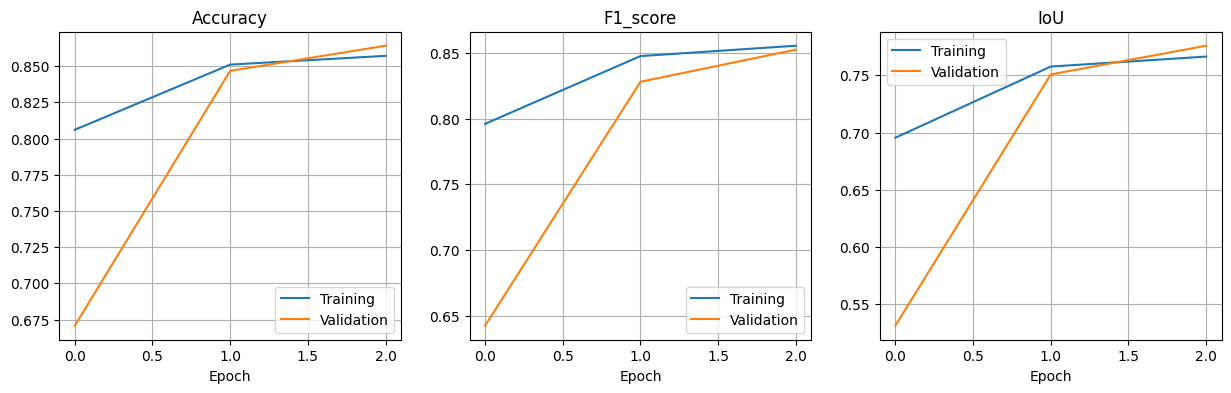

In [14]:
rawDF = pd.DataFrame(model_unet_history.history)
plotDF = pd.DataFrame()

try:
    # Find the number behind the _ in the keys
    number = rawDF.columns[1].split('_')[-1]
    rawDF = rawDF.rename(columns={'true_positives_' + number : 'true_positives', 'true_negatives_'+number: 'true_negatives', 'false_positives_'+number: 'false_positives', 'false_negatives_'+number: 'false_negatives',
                                    'val_true_positives_'+number: 'val_true_positives', 'val_true_negatives_'+number: 'val_true_negatives', 'val_false_positives_'+number: 'val_false_positives', 'val_false_negatives_'+number: 'val_false_negatives'})
except:
    pass

plotDF['Accuracy']     = (rawDF['true_positives'] + rawDF['true_negatives']) / (rawDF['true_positives'] + rawDF['true_negatives'] + rawDF['false_positives'] + rawDF['false_negatives'])
plotDF['val_Accuracy'] = (rawDF['val_true_positives'] + rawDF['val_true_negatives']) / (rawDF['val_true_positives'] + rawDF['val_true_negatives'] + rawDF['val_false_positives'] + rawDF['val_false_negatives'])

plotDF['IoU']          = rawDF['true_positives'] / (rawDF['true_positives'] + rawDF['false_positives'] + rawDF['false_negatives'])
plotDF['val_IoU']      = rawDF['val_true_positives'] / (rawDF['val_true_positives'] + rawDF['val_false_positives'] + rawDF['val_false_negatives'])

plotDF['F1_score']     = rawDF['F1_score']
plotDF['val_F1_score'] = rawDF['val_F1_score']

list_of_metrics=['Accuracy', 'F1_score', 'IoU']
train_keys = list_of_metrics
valid_keys = ['val_' + key for key in list_of_metrics]
nr_plots = len(list_of_metrics)
fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
for i in range(len(list_of_metrics)):
    ax[i].plot(np.array(plotDF[train_keys[i]]), label='Training')
    ax[i].plot(np.array(plotDF[valid_keys[i]]), label='Validation')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(list_of_metrics[i])
    ax[i].grid('on')
    ax[i].legend()
fig.tight_layout
plt.show()

In [15]:
print(model_unet_history.history['F1_score'][-1])

0.8556792736053467


## Task 1.3 Visualize model predictions

Make a plot that illustrates the original image, the predicted mask, and the ground truth mask.

### Plotting

1/1 [==============================] - 2s 2s/step


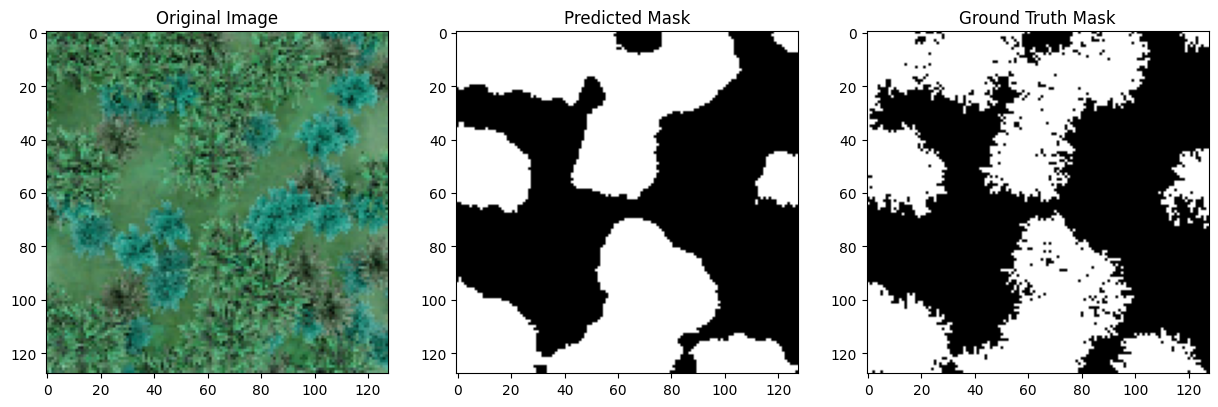

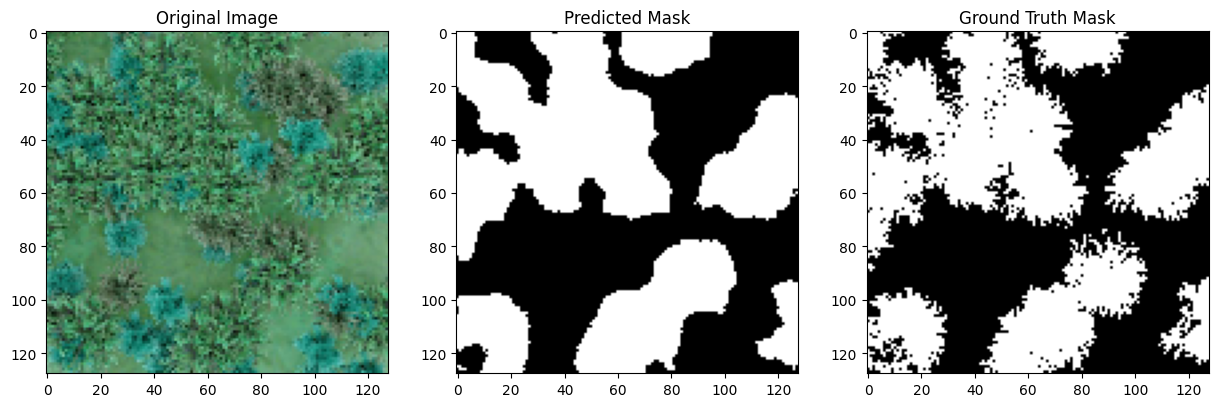

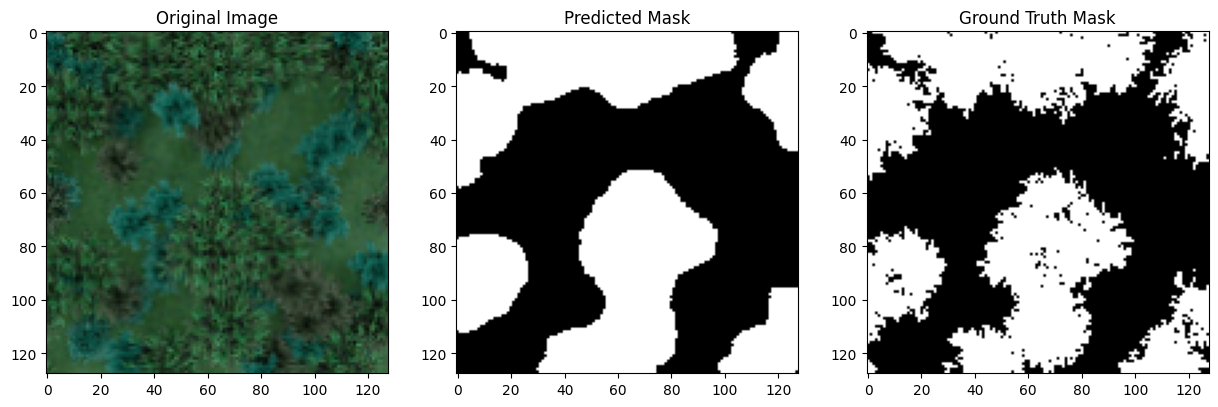

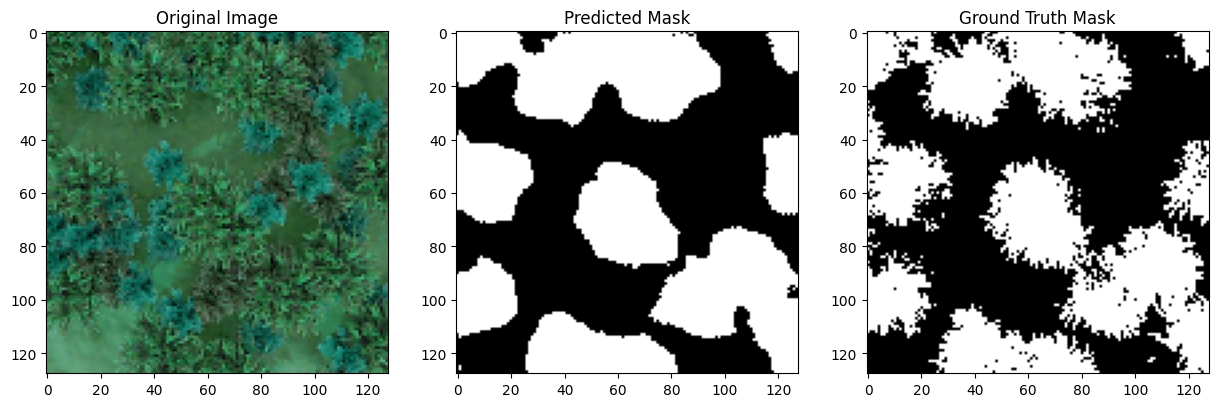

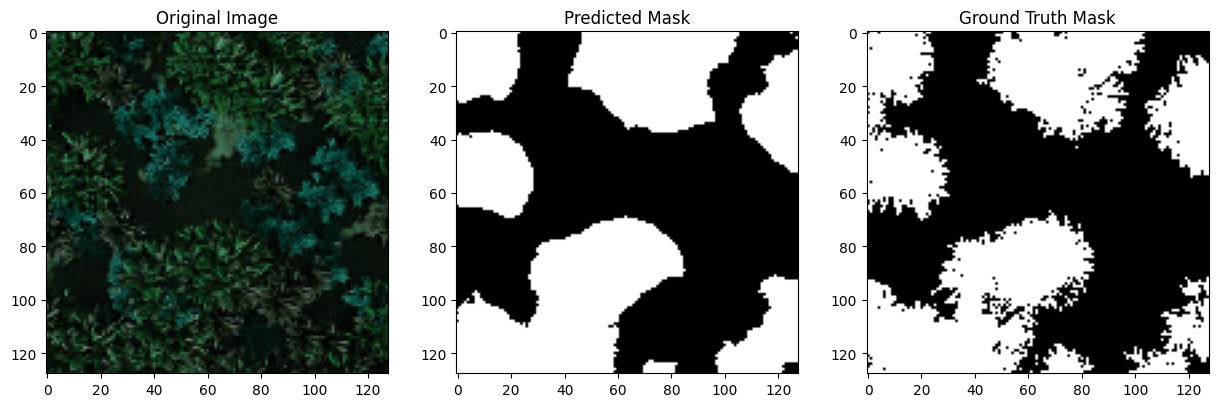

In [16]:
# Predict masks for a few images in the training set
y_pred = model_unet.predict(X_train[:5])

# Convert predicted masks to binary
y_pred_binary = np.argmax(y_pred, axis=-1)

# Convert ground truth masks to binary
y_train_binary = np.argmax(y_train[:5], axis=-1)

# Plot the original image, predicted mask, and ground truth mask for each image
for i in range(5):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(X_train[i].squeeze(), cmap='gray')
  axes[0].set_title('Original Image')
  axes[1].imshow(y_pred_binary[i], cmap='gray')
  axes[1].set_title('Predicted Mask')
  axes[2].imshow(y_train_binary[i], cmap='gray')
  axes[2].set_title('Ground Truth Mask')
  plt.show()

# Part 2: Implementing U-net with transfer learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. There are many pre-trained back-bones to choose from. Pick freely from the selection here [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), or here [Keras model scores](https://keras.io/api/applications/) (nicer table in the second link). Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers. It might be expedient to only train them for 1-5 epochs on your PCs, and do the full training on Orion in Part 3.


#### For those with a dedicated graphics card (NVIDIA and AMD) Tensorflow or PyTorch (not syllabus)
And wants to experiment with their own compute resources (can be alot of fun)\
Tensorflow: https://learn.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-plugin \
PyTorch: https://learn.microsoft.com/en-us/windows/ai/directml/pytorch-windows

## Task 2.1 Transfer learning model implementation

Implement a U-net model utilizing the pre-trained weights of a publically available network. **Remember to compile with the F1-score metric**.

### Transfer learning with U-net

In [19]:
def unet_efficientnetb7(input_shape, dropout_rate=0.1):
    # Input layer
    inputs = ks.layers.Input(shape=input_shape)
    # Pretrained EfficientNetB7 encoder
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=inputs)
    # Encoder blocks (skip connections)
    block1 = base_model.get_layer('block1a_activation').output  # (None, 64, 64, 64)
    block2 = base_model.get_layer('block2a_activation').output  # (None, 32, 32, 192)
    block3 = base_model.get_layer('block3a_activation').output  # (None, 16, 16, 288)
    block4 = base_model.get_layer('block5a_activation').output  # (None, 8, 8, 960)

    # Middle block
    block5 = base_model.get_layer('top_activation').output      # (None, 4, 4, 256)

    # Decoder blocks
    x5 = upsample_block(block5, block4, 960) # (None, 8, 8, 960)
    x4 = upsample_block(x5, block3, 288)    # (None, 16, 16, 288)
    x3 = upsample_block(x4, block2, 192)   # (None, 32, 32, 192)
    x2 = upsample_block(x3, block1, 64)  # (None, 64, 64, 64)

    # Final upsample and output layer
    x = ks.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(x2)  # Final upsample layer (None, 128, 128, 32)
    output = ks.layers.Conv2D(2, (1, 1), padding="same", activation="softmax")(x)  # Output layer (None, 128, 128, 1)

    # Create the model
    unet_model = ks.models.Model(inputs, output)

    return unet_model

input_img = (128, 128, 3)
model_pre = unet_efficientnetb7(input_img)
model_pre.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 128, 128, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 128, 128, 3)          0         ['normalization_1[0][0]'

## Task 2.2 Train the transfer learning model and plot the training history

Feel free to use the `plot_training_history` function from the provided library `utilities.py`

### Training

In [20]:
early_stopping = ks.callbacks.EarlyStopping(monitor='val_F1_score',
                               patience=5,
                              mode='max',
                               restore_best_weights=True)

# Compile the model
model_pre.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[FalseNegatives(),
                       FalsePositives(),
                       TrueNegatives(),
                       TruePositives(),
                       F1_score])

# Train the model
model_pre_history = model_pre.fit(X_train, y_train,
                             epochs=3, # more on orion
                             batch_size=32,
                             validation_split=(1/8),
                             callbacks=[early_stopping])

model_pre.save('model_pre.keras')

Epoch 1/3
197/197 [==============================] - 1114s 5s/step - loss: 0.3740 - false_negatives_3: 26558032.0000 - false_positives_3: 10120247.0000 - true_negatives_3: 76661208.0000 - true_positives_3: 93098960.0000 - F1_score: 0.8162 - val_loss: 0.8564 - val_false_negatives_3: 9140217.0000 - val_false_positives_3: 6900541.0000 - val_true_negatives_3: 5605383.0000 - val_true_positives_3: 7845059.0000 - val_F1_score: 0.4294
Epoch 2/3
197/197 [==============================] - 984s 5s/step - loss: 0.3312 - false_negatives_3: 22397440.0000 - false_positives_3: 5959666.0000 - true_negatives_3: 80821728.0000 - true_positives_3: 97259520.0000 - F1_score: 0.8580 - val_loss: 0.9243 - val_false_negatives_3: 6288623.0000 - val_false_positives_3: 4048944.0000 - val_true_negatives_3: 8456980.0000 - val_true_positives_3: 10696653.0000 - val_F1_score: 0.6389
Epoch 3/3
197/197 [==============================] - 979s 5s/step - loss: 0.3217 - false_negatives_3: 22307842.0000 - false_positives_3: 58

### Plotting

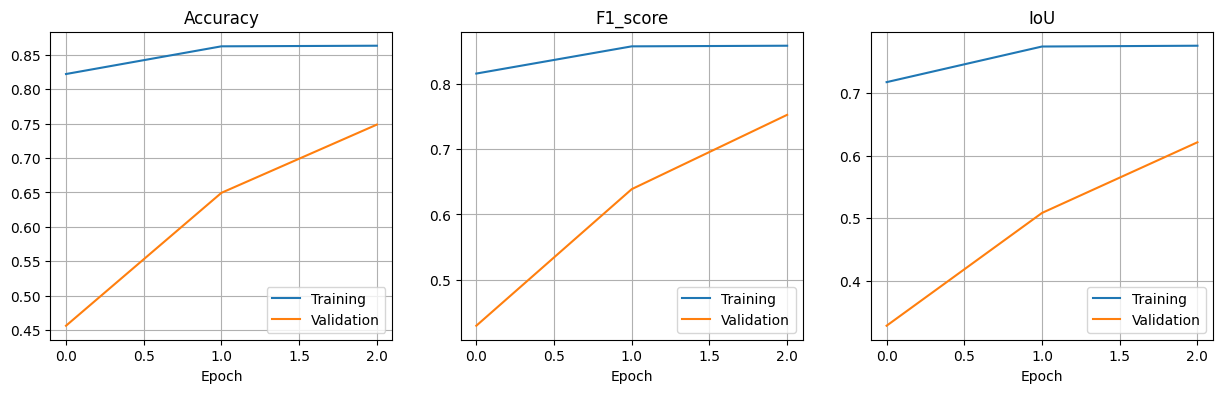

In [23]:
rawDF = pd.DataFrame(model_pre_history.history)
plotDF = pd.DataFrame()

try:
    # Find the number behind the _ in the keys
    number = rawDF.columns[1].split('_')[-1]
    rawDF = rawDF.rename(columns={'true_positives_' + number : 'true_positives', 'true_negatives_'+number: 'true_negatives', 'false_positives_'+number: 'false_positives', 'false_negatives_'+number: 'false_negatives',
                                    'val_true_positives_'+number: 'val_true_positives', 'val_true_negatives_'+number: 'val_true_negatives', 'val_false_positives_'+number: 'val_false_positives', 'val_false_negatives_'+number: 'val_false_negatives'})
except:
    pass

plotDF['Accuracy']     = (rawDF['true_positives'] + rawDF['true_negatives']) / (rawDF['true_positives'] + rawDF['true_negatives'] + rawDF['false_positives'] + rawDF['false_negatives'])
plotDF['val_Accuracy'] = (rawDF['val_true_positives'] + rawDF['val_true_negatives']) / (rawDF['val_true_positives'] + rawDF['val_true_negatives'] + rawDF['val_false_positives'] + rawDF['val_false_negatives'])

plotDF['IoU']          = rawDF['true_positives'] / (rawDF['true_positives'] + rawDF['false_positives'] + rawDF['false_negatives'])
plotDF['val_IoU']      = rawDF['val_true_positives'] / (rawDF['val_true_positives'] + rawDF['val_false_positives'] + rawDF['val_false_negatives'])

plotDF['F1_score']     = rawDF['F1_score']
plotDF['val_F1_score'] = rawDF['val_F1_score']

list_of_metrics=['Accuracy', 'F1_score', 'IoU']
train_keys = list_of_metrics
valid_keys = ['val_' + key for key in list_of_metrics]
nr_plots = len(list_of_metrics)
fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
for i in range(len(list_of_metrics)):
    ax[i].plot(np.array(plotDF[train_keys[i]]), label='Training')
    ax[i].plot(np.array(plotDF[valid_keys[i]]), label='Validation')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(list_of_metrics[i])
    ax[i].grid('on')
    ax[i].legend()
fig.tight_layout
plt.show()

# Part 3: Training your model Orion

Use the lecture slides from the Orion-lecture to get started.
1. Put one of your model implementations into a python script (`.py`)
2. Transfer that script to Orion.
3. Change the relevant path variables in your python script (path-to-data for example), and make sure that you record the time it takes to train the model in the script. This can be done using the `time` library for example.
4. Set up a SLURM-script to train your model, please use the example from the Orion lecture as a base.
5. Submit your SLURM job, and let the magic happen.

If you wish to use a model trained on Orion to make a Kaggle submission, remember to save the model, such that you can transfer it to your local computer to make a prediction on `X_test`, or test the model on Orion directly if you want to.

## Tips

If you compiled, trained and stored a model on Orion with a custom performance metric (such as F1-score), remember to specify that metric when loading the model on your computer again.

Loading a saved model:
```python
trained_model = tf.keras.models.load_model('some/path/to/my_trained_model.keras', custom_objects={'F1_score': F1_score})
```

Loading a checkpoint:
```python
trained_model = tf.keras.saving.load_model('some/path/to/my_trained_model_checkpoint', custom_objects={'F1_score': F1_score})
```

# Discussion

**Question 1: Which model architectures did you explore, and what type of hyperparameter optimization did you try?**

**Answer 1:** We experimented with the efficientnet model.

For the native u-net model we tried different multiplums of two for the number of filters in each convulutional blocks.
We also experimented with different numbers of epochs and batch sizes, and how much dropout to include.  We tuned the paramneters by nested for loops, just like a grid search, we should in hindsight maybe used random search to test more hyperparms. We found that the best params were a learning rate of 0.1 , dropout of 0.2, batch size of 32, and base for the convolutional filters of 32.
We also tried some augnmentation of the images with, rotating, and scaling but this did not increase the performance so was not included here. Different loss functions such as binary focal cross entropy and dice loss was also explored because of the slight imbalance in the dataset, but did not lead to any noticable increase in performance. Training without batchnormalization was also explored, but resulted in poorer performance. L2-regularization was also explored a bit, but resulted in very noisy training performance with values larger than 0.0001. We are unsure wheter l2 regularization with smaller values would be beneficial.

**Question 2: Which of the model(s) did you choose to train on Orion, and how long did it take to train it on Orion?**

**Answer 2:**
We tried to train both models on Orion but got the best performance from the model native Unet model without the pretrained backbone. On the native U-net model the model used 123 seconds on google colab, and only 7 seconds per epoch on orion. Orion is 17,5 times faster than training on colab.


**Question 3: What where the biggest challenges with this assignment?**

**Answer 3:** One of the biggest challenges was implementing the model with a pretrained backbone, it was challenging to find out exactly where the skip connections should be. Implementing the U-Net model in itself was also quite hard, since we did not really know what activation function we were to use on the last layer, we tried with both sigmoid and softmax, but found that sigmoid gave the best result. Implementing data augmentation was also a bit challenging, because it was necessary to apply the same augmentation to both images and masks. Also figuring out what type, if any, of data augmentation would be useful also took some time, and we concluded that we were not able to increase the model performance by augmenting the data.



# Kaggle submission

Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard.
Link to the Kaggle leaderboard will be posted in the Canvas assignment.

### Kaggle submission

In [25]:
FILE_PATH = "tree_test.h5" # If data is in same directory as Jypyter File

with h5py.File(FILE_PATH,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_test = np.asarray(f['X'])
    print('Nr. train images: %i'%(X_test.shape[0]))

# Turn to grey scale images
X_test = np.expand_dims(X_test, -1)
X_test = X_test.astype("float32")/255

Datasets in file: ['X']
Nr. train images: 800


In [26]:
# Threshold for sigmoid
USER_DETERMINED_THRESHOLD = 0.5

y_pred      = model_pre.predict(X_test)  # Make prediction using the trained model
flat_y_pred = y_pred.flatten()                             # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1  # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                        # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))               # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

25/25 [==============================] - 34s 951ms/step


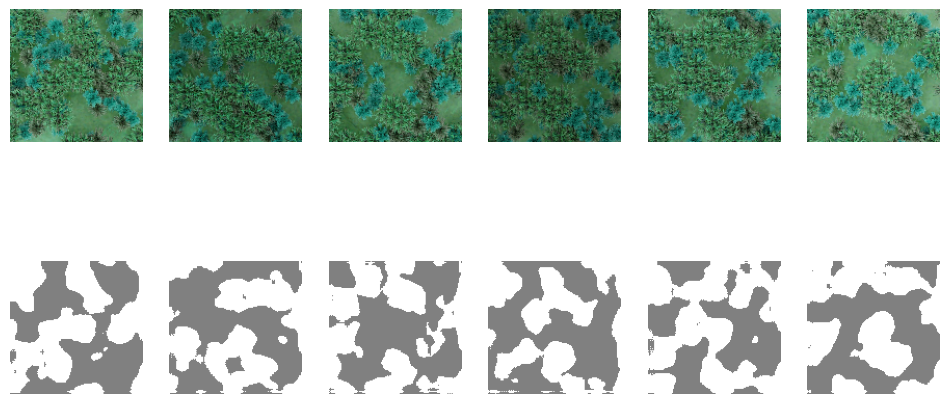

In [29]:
# Make shure predictions look ok
plt.figure(figsize=(12, 6))
for i in range(6):
    image_x = np.squeeze(X_test[i])
    plt.subplot(2, 6, i + 1)
    plt.imshow(image_x)
    plt.axis("off")
    plt.subplot(2, 6, i + 7)
    plt.imshow(np.argmax(y_pred[i], axis=-1), cmap='gray', alpha=0.5)
    plt.axis("off")
plt.savefig('bard_2_test.png')

# Orion

Here is some plots gotten from the training of the model on Orion.

### Training history

# Appendix
Links to fun and interessting learning resources \
(not so much for this compulsary assignment, more for your own learning and interests):

- <a href="https://streamlit.io/">Streamlit</a>
- <a href="https://github.com/mlabonne/llm-datasets?tab=readme-ov-file">LLM-datasets</a>
- <a href="https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python">Hands-On Graph Neural Networks Using Python</a>
- <a href="https://github.com/mlabonne/llm-course">LLM Course</a>
- <a href="https://bbycroft.net/llm">LLM by Bycroft</a>
- <a href="https://groq.com/">Groq</a>
- <a href="https://unstructured.io/?fob=kxzdntwfMj4TVNSV">Unstructured.io</a>
- <a href="https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=a_rjVo-RAoYd">Google Colab TPU Notebook</a>
- <a href="https://github.com/langchain-ai/langgraph/tree/main">LangGraph RAG Agent Llama3 Local</a>
- <a href="https://python.langchain.com/docs/how_to/">LangChain Python Docs</a>
- <a href="https://www.nomic.ai/blog/posts/nomic-embed-text-v1">Nomic Embed Text v1</a>
- <a href="https://duckdb.org/docs/api/python/overview.html">DuckDB Python API Overview</a>
- <a href="https://jsoncrack.com/editor">JSON Crack Editor</a>
- <a href="https://learn.microsoft.com/en-us/azure/data-factory/transform-data-machine-learning-service">Azure Data Factory Machine Learning Service</a>

- <a href="https://learn.microsoft.com/en-us/azure/databricks/machine-learning/">Azure Databricks Machine Learning</a>
- <a href="https://github.com/katanaml">Katana ML - Machine Learning for Business Automation</a>
- <a href="https://deckgl.readthedocs.io/en/latest/">Pydeck - High-scale spatial rendering in Python, powered by deck.gl</a>




